In [1]:
!git clone https://github.com/LizaDerb/probing_compositionality/

Cloning into 'probing_compositionality'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 427 (delta 57), reused 8 (delta 8), pack-reused 225
Receiving objects: 100% (427/427), 155.24 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Updating files: 100% (85/85), done.


# Russian VP

## Датасет

In [2]:
import pandas as pd

In [3]:
rus = pd.read_csv('/content/probing_compositionality/data/rus/extended_vp_corpus.csv', sep=';')

Одно и то же выражение имеет и буквальное, и идиоматическое употребление. Все выражения - VP.

In [4]:
rus = rus[['mwe', 'label', 'short_sentence']].rename(columns={'short_sentence' : 'sentence'})

In [5]:
rus.head()

,mwe,label,sentence
0,жирно будет,I,"Нет, о ""пятерке"" говорить конечно даже не прих..."
1,жирно будет,I,"В том роде, как тогда на Фотьянке. Так вот как..."
2,жирно будет,I,"Больше не проси, потому,-- не дам: больно жирн..."
3,жирно будет,I,Отпущу я его на заработки! А самому небось бат...
4,жирно будет,I,"-- Ну, уж слуга покорный! -- огрызнулся Сарма..."


<Axes: xlabel='mwe'>

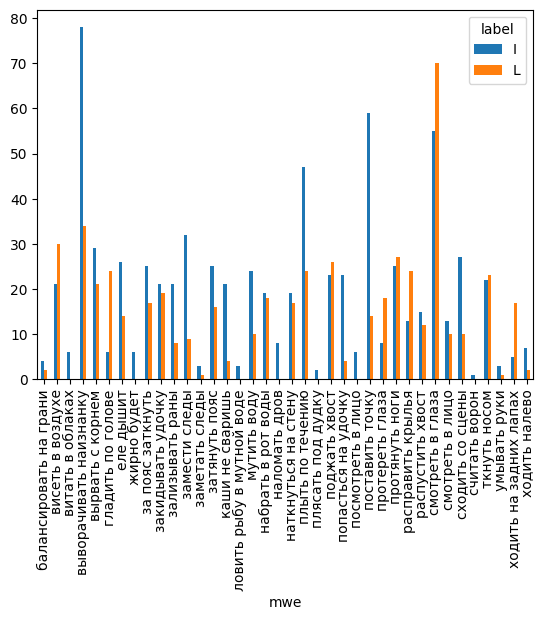

In [6]:
rus.groupby(['mwe', 'label']).size().unstack().plot(kind='bar')

In [7]:
num_idiom = rus['mwe'].value_counts()
num_idiom

mwe
смотреть в глаза             125
выворачивать наизнанку       112
поставить точку               73
плыть по течению              71
протянуть ноги                52
висеть в воздухе              51
вырвать с корнем              50
поджать хвост                 49
ткнуть носом                  45
за пояс заткнуть              42
замести следы                 41
затянуть пояс                 41
закидывать удочку             40
еле дышит                     40
набрать в рот воды            37
сходить со сцены              37
расправить крылья             37
наткнуться на стену           36
мутить воду                   34
гладить по голове             30
зализывать раны               29
попасться на удочку           27
распустить хвост              27
протереть глаза               26
каши не сваришь               25
смотреть в лицо               23
ходить на задних лапах        22
ходить налево                  9
наломать дров                  8
жирно будет                    6
баланс

In [8]:
idiom_train = num_idiom[:14].index.tolist()
idiom_test = num_idiom[14:].index.tolist()

rus_train = rus[rus['mwe'].isin(idiom_train)]
rus_test = rus[rus['mwe'].isin(idiom_test)]

rus_train = rus_train.dropna()

print('train: ', len(rus_train))
print('test: ', len(rus_test))

train:  830
test:  445


In [9]:
stat_train_rus = rus_train['label'].value_counts().rename('num').to_frame()
stat_train_rus['percentage'] = (stat_train_rus.num * 100 / stat_train_rus.num.sum()).round(1).astype(str) + '%'
stat_train_rus

,num,percentage
label,,
I,488,58.8%
L,342,41.2%


In [10]:
stat_test_rus = rus_test['label'].value_counts().rename('num').to_frame()
stat_test_rus['percentage'] = (stat_test_rus.num * 100 / stat_test_rus.num.sum()).round(1).astype(str) + '%'
stat_test_rus

,num,percentage
label,,
I,263,59.1%
L,182,40.9%


## RuBERT

In [ ]:
!pip install datasets

In [12]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

In [13]:
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import warnings
import random
import pickle

import torch
from torch.utils.data import DataLoader

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel

In [14]:
train = Dataset.from_pandas(rus_train)
test = Dataset.from_pandas(rus_test)

In [15]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [16]:
train_labels = le.transform(train['label'])
test_labels = le.transform(test['label'])

In [17]:
train

Dataset({
    features: ['mwe', 'label', 'sentence', '__index_level_0__'],
    num_rows: 830
})

In [18]:
test

Dataset({
    features: ['mwe', 'label', 'sentence', '__index_level_0__'],
    num_rows: 445
})

In [19]:
rubert_tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
rubert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
torch.cuda.is_available()

True

In [21]:
device_cuda = torch.device("cuda")
device_cpu = torch.device("cpu")

In [22]:
def vectorize_dataset(data, tokenizer, model):
    model = model.to(device_cuda)
    res_cls = []
    res_mean = []
    for batch in tqdm(data):
        toks = tokenizer(batch['sentence'], padding='max_length', truncation=True, return_tensors='pt', max_length=300)
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in toks.items()})
        res_cls.append(model_output.last_hidden_state[:,0,:]) #достаём вектора для CLS токенов
        res_mean.append(torch.mean(model_output.last_hidden_state, dim=1)) #среднее
    res_cls = torch.vstack(res_cls)
    res_mean = torch.vstack(res_mean)
    return res_cls.detach().cpu().numpy(), res_mean.detach().cpu().numpy()

In [23]:
dl_train = DataLoader(train, batch_size=256, shuffle=False,
                drop_last=False)
dl_test = DataLoader(test, batch_size=256, shuffle=False,
                drop_last=False)
vecs_train_cls, vecs_train_mean = vectorize_dataset(dl_train, rubert_tokenizer, rubert)
vecs_test_cls, vecs_test_mean = vectorize_dataset(dl_test, rubert_tokenizer, rubert)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
vectors = {'vecs_train_cls' : vecs_train_cls, 'vecs_train_mean' : vecs_train_mean,
           'vecs_test_cls' : vecs_test_cls, 'vecs_test_mean' : vecs_test_mean}

for name in vectors.keys():
    with open(f'{name}.pkl', 'wb') as file:
         pickle.dump(vectors[name], file)

In [25]:
vector_names = ['vecs_train_cls', 'vecs_train_mean', 'vecs_test_cls', 'vecs_test_mean']
vecs = []

for name in vector_names:
    with open(f'{name}.pkl', "rb") as fIn:
        vecs.append(pickle.load(fIn))

train_cls = vecs[0]
train_mean = vecs[1]
test_cls = vecs[2]
test_mean = vecs[3]

In [26]:
train_cls.shape

(830, 768)

In [27]:
test_mean.shape

(445, 768)

In [28]:
def calculate_metrics(true_labels, predictions):
    matrix = confusion_matrix(true_labels, predictions)
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)
    return matrix, acc, prec, rec, f1, roc_auc

In [29]:
def baseline_rand_vec(vecs):
    size = vecs.shape[1]
    num_vecs = vecs.shape[0]
    rand_vecs = []
    for _ in range(num_vecs):
        rand_vecs.append(np.random.uniform(-5.0826163,1.5603778,size))
    return rand_vecs

In [30]:
def baseline_rand_pred(vecs, labels):
    num_vecs = vecs.shape[0]
    rand_vecs = []
    rand_pred = np.array(range(num_vecs), dtype=int)
    for i in range(0, num_vecs):
        rand_pred[i] = random.choice(labels)
    return rand_pred

In [31]:
def rand_pred_func(vecs, labels, true_labels, n=50):
    results_rand_pred = []
    for _ in range(n):
        pred_labels = baseline_rand_pred(vecs, labels)
        results_rand_pred.append(calculate_metrics(true_labels, pred_labels))
    res_rand_pred = pd.DataFrame(results_rand_pred, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    res_rand_pred.to_csv('res_rand_pred.csv')

In [32]:
def get_results(train_data, train_labels, test_data, test_labels):
    results_train = []
    results_test = []
    for n in tqdm(range(50)):
        clf = MLPClassifier(random_state=n, max_iter=300, verbose=1)
        clf.fit(train_data, train_labels)
        train_pred = clf.predict(train_data)
        test_pred = clf.predict(test_data)
        results_train.append(calculate_metrics(train_labels, train_pred))
        results_test.append(calculate_metrics(test_labels, test_pred))
    return results_train, results_test, test_pred

In [33]:
labels = [0, 1]

In [34]:
rand_pred_func(test_cls, labels, test_labels)

In [ ]:
rand_vecs = baseline_rand_vec(train_cls)
results_train_rand, results_test_rand, test_pred_rand = get_results(rand_vecs, train_labels, test_cls, test_labels)
res_test_rand = pd.DataFrame(results_test_rand, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_rand = pd.DataFrame(results_train_rand, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_rand.to_csv('res_test_rand_vec.csv')
res_train_rand.to_csv('res_train_rand_vec.csv')

In [ ]:
results_train_mean, results_test_mean, test_pred_mean = get_results(train_mean, train_labels, test_mean, test_labels)
res_test_mean = pd.DataFrame(results_test_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_mean = pd.DataFrame(results_train_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_mean.to_csv('res_test_mean.csv')
res_train_mean.to_csv('res_train_mean.csv')

In [37]:
print(classification_report(test_labels, test_pred_mean, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.78      0.78      0.78       263
           L       0.68      0.68      0.68       182

    accuracy                           0.74       445
   macro avg       0.73      0.73      0.73       445
weighted avg       0.74      0.74      0.74       445



In [ ]:
results_train_cls, results_test_cls, test_pred_cls = get_results(train_cls, train_labels, test_cls, test_labels)
res_test_cls = pd.DataFrame(results_test_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_cls = pd.DataFrame(results_train_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_cls.to_csv('res_test_cls.csv')
res_train_cls.to_csv('res_train_cls.csv')

In [39]:
print(classification_report(test_labels, test_pred_cls, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.81      0.86      0.84       263
           L       0.78      0.71      0.74       182

    accuracy                           0.80       445
   macro avg       0.80      0.79      0.79       445
weighted avg       0.80      0.80      0.80       445



In [40]:
!zip -r /content/file.zip /content/russian_vp

	zip warning: name not matched: /content/russian_vp

zip error: Nothing to do! (try: zip -r /content/file.zip . -i /content/russian_vp)
